Javier Alemán Rodríguez

# DengAI: Predicción de la propagación de enfermedades

## Extracción y transformación de datos

### Importación de librerías

Instalamos las librería necesarias mediante uno de los siguientes comandos:

```
pip install [nombre librería]
``` 

```
!pip install [nombre librería]
``` 

```
%pip install [nombre librería]
``` 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics
from scipy import cluster
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import uniform, randint
from sklearn.metrics import mean_absolute_error

In [2]:
url = 'https://raw.githubusercontent.com/JaviARo/Datasets/main/DengAI'

dengue_labels_train = pd.read_csv(f'{url}/dengue_labels_train.csv')
dengue_features_train = pd.read_csv(f'{url}/dengue_features_train.csv')
dengue_features_test = pd.read_csv(f'{url}/dengue_features_test.csv')

In [3]:
dengue_labels_train.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [4]:
dengue_features_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.12,0.10,0.20,0.18,12.42,297.57,...,32.00,73.37,12.42,14.01,2.63,25.44,6.90,29.40,20.00,16.00
1,sj,1990,19,1990-05-07,0.17,0.14,0.16,0.16,22.82,298.21,...,17.94,77.37,22.82,15.37,2.37,26.71,6.37,31.70,22.20,8.60
2,sj,1990,20,1990-05-14,0.03,0.17,0.16,0.17,34.54,298.78,...,26.10,82.05,34.54,16.85,2.30,26.71,6.49,32.20,22.80,41.40
3,sj,1990,21,1990-05-21,0.13,0.25,0.23,0.24,15.36,298.99,...,13.90,80.34,15.36,16.67,2.43,27.47,6.77,33.30,23.30,4.00
4,sj,1990,22,1990-05-28,0.20,0.26,0.25,0.25,7.52,299.52,...,12.20,80.46,7.52,17.21,3.01,28.94,9.37,35.00,23.90,5.80


In [5]:
dengue_features_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.02,-0.02,0.10,0.09,78.60,298.49,...,25.37,78.78,78.60,15.92,3.13,26.53,7.06,33.30,21.70,75.20
1,sj,2008,19,2008-05-06,-0.02,-0.01,0.08,0.07,12.56,298.48,...,21.83,78.23,12.56,15.79,2.57,26.07,5.56,30.00,22.20,34.30
2,sj,2008,20,2008-05-13,-0.00,NaN,0.15,0.09,3.66,299.46,...,4.12,78.27,3.66,16.67,4.43,27.93,7.79,32.80,22.80,3.00
3,sj,2008,21,2008-05-20,NaN,-0.02,0.12,0.13,0.00,299.69,...,2.20,73.02,0.00,15.78,4.34,28.06,6.27,33.30,24.40,0.30
4,sj,2008,22,2008-05-27,0.06,0.04,0.06,0.08,0.76,299.78,...,4.36,74.08,0.76,16.14,3.54,27.61,7.09,33.30,23.30,84.10


## Limpieza de datos

In [6]:
def NumericalDataScaler(df):
  # Selección de columnas numéricas
  numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

  preprocessor_RR = ColumnTransformer([('scale', MinMaxScaler(), numeric_cols)],remainder='passthrough')

  df[numeric_cols] = preprocessor_RR.fit_transform(df[numeric_cols])
  return df

def CategoricalToNumerical(df, categorical_cols): 
	le = LabelEncoder()

	for col in categorical_cols: 
		df[col] = le.fit_transform(df[col])    
	return df

In [7]:
X = dengue_features_train.drop(columns=["week_start_date"], axis=1)
X = CategoricalToNumerical(X, ["city"])
X = NumericalDataScaler(X)
X = X.fillna(X.mean())
y = dengue_labels_train['total_cases']
X.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,0.00,0.33,0.58,0.61,0.39,0.40,0.03,0.39,0.35,...,0.06,0.38,0.03,0.26,0.09,0.43,0.21,0.17,0.49,0.03
1,1,0.00,0.35,0.63,0.66,0.32,0.36,0.06,0.47,0.44,...,0.03,0.48,0.06,0.42,0.07,0.57,0.16,0.32,0.69,0.02
2,1,0.00,0.37,0.48,0.69,0.31,0.38,0.09,0.55,0.50,...,0.05,0.59,0.09,0.59,0.06,0.57,0.17,0.35,0.74,0.08
3,1,0.00,0.38,0.58,0.77,0.44,0.49,0.04,0.58,0.54,...,0.02,0.55,0.04,0.57,0.07,0.65,0.20,0.43,0.79,0.01
4,1,0.00,0.40,0.66,0.79,0.48,0.51,0.02,0.65,0.59,...,0.02,0.56,0.02,0.63,0.11,0.80,0.43,0.54,0.84,0.01


## Separación de variables de entrenamiento y test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Selección de características

### SelectKBest

In [9]:
def ApplySelectKBest(X_train, X_test, y_train, k):
	selector = SelectKBest(f_regression, k=k)

	selector.fit_transform(X_train, y_train)
	selector.transform(X_test)

	print(f"Mejores {k} columnas = [")
	for col in selector.get_feature_names_out():
		print(f"  \'{col}\'")
	print("]\n")

In [10]:
ApplySelectKBest(X_train, X_test, y_train, k=1)
ApplySelectKBest(X_train, X_test, y_train, k=6)
ApplySelectKBest(X_train, X_test, y_train, k=10)
ApplySelectKBest(X_train, X_test, y_train, k=15)

Mejores 1 columnas = [
  'reanalysis_min_air_temp_k'
]

Mejores 6 columnas = [
  'city'
  'year'
  'reanalysis_air_temp_k'
  'reanalysis_min_air_temp_k'
  'reanalysis_tdtr_k'
  'station_min_temp_c'
]

Mejores 10 columnas = [
  'city'
  'year'
  'weekofyear'
  'reanalysis_air_temp_k'
  'reanalysis_avg_temp_k'
  'reanalysis_max_air_temp_k'
  'reanalysis_min_air_temp_k'
  'reanalysis_tdtr_k'
  'station_diur_temp_rng_c'
  'station_min_temp_c'
]

Mejores 15 columnas = [
  'city'
  'year'
  'weekofyear'
  'ndvi_ne'
  'ndvi_nw'
  'reanalysis_air_temp_k'
  'reanalysis_avg_temp_k'
  'reanalysis_dew_point_temp_k'
  'reanalysis_max_air_temp_k'
  'reanalysis_min_air_temp_k'
  'reanalysis_specific_humidity_g_per_kg'
  'reanalysis_tdtr_k'
  'station_avg_temp_c'
  'station_diur_temp_rng_c'
  'station_min_temp_c'
]



### Dendrograma

Distancia Media	  13.06


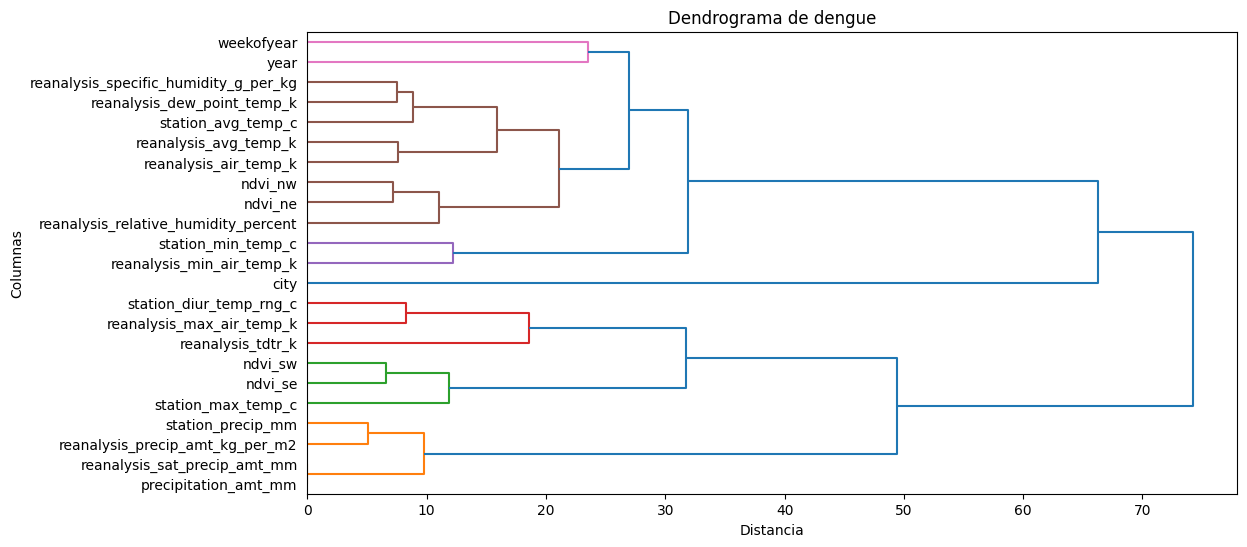

In [11]:
X_T = X.T

dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
D = dist.pairwise(X_T)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

plt.figure(figsize=(12, 6))
plt.title('Dendrograma de dengue')
plt.xlabel('Distancia')
plt.ylabel('Columnas')
threshold_2 = 26

clusters = cluster.hierarchy.linkage(D, method='complete')
cluster.hierarchy.dendrogram(clusters, color_threshold=threshold_2, labels=X.columns.to_list(), orientation='right')
plt.show()

Se generan 7 grupos, de los cuales cogemos las siguientes caracteristicas:

* Grupo 1: **year** (está entre las mejores 6 columas por SelectKBest)
* Grupo 2: **reanalysis_air_temp_k** (está entre las mejores 6 columas por SelectKBest)
* Grupo 3: **reanalysis_min_air_temp_k** (está entre las mejores 6 columas por SelectKBest)
* Grupo 4: **city** (está entre las mejores 6 columas por SelectKBest)
* Grupo 5: **reanalysis_tdtr_k** (está entre las mejores 6 columas por SelectKBest)
* Grupo 6: **station_min_temp_c** (está entre las mejores 6 columas por SelectKBest)
* Grupo 7: No existe ninguna columna significativa de este grupo entre las 15 mejores columnas

In [12]:
X = X[[
  'city',
  'year',
  'weekofyear',
  'reanalysis_air_temp_k',
  'reanalysis_avg_temp_k',
  'reanalysis_max_air_temp_k',
  'reanalysis_min_air_temp_k',
  'reanalysis_tdtr_k',
  'station_diur_temp_rng_c',
  'station_min_temp_c'
]]

### Matriz de correlación

Mostramos la matriz de correlación con las características seleccionadas

Text(0.5, 1.0, 'Matriz de correlación')

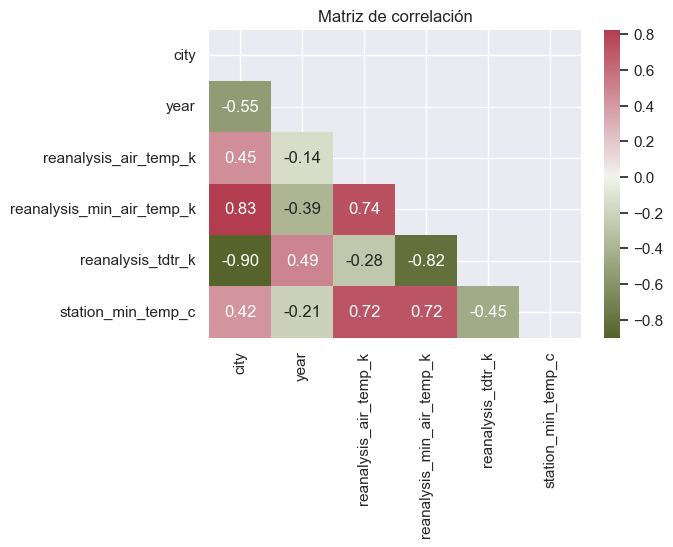

In [14]:
sns.set()

# Calcular la matriz de correlación
corr_mat_data = X.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool)) # Recorta la gráfica

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

plt.figure(figsize = (6, 4))
# sns.heatmap(X.corr(), square=True, annot=True)
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Matriz de correlación')

He decidido no quitar ninguna característica más tras mostrar la matriz de correlación por los siguientes motivos:

1. De las dos variables correlacionadas en un 83%, la más propensa a eliminarse es 'reanalysis_min_air_temp' al estar también bien correlacionada con 'station_min_temp_c' y guardar correlación negativa con 'reanalysis_tdtr_k'; no obstante, es la columna con mayor relevancia en el dataset según SelectKBest, por tanto no la quito.
2. Al no conocer en profundidad el tema tratado en los datos, prefiero no quitar caracteristicas por guardar una correlación negativa.

### División de los datos de train, test y validación

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=1)

## Selección del modelo

### LazyPredict

Utilizamos la herramienta LazyPredict para determinar los mejores modelos a aplicar

In [14]:
rgr = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = rgr.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 42/42 [00:02<00:00, 14.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 10
[LightGBM] [Info] Start training from score 25.524914
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
XGBRegressor                                 0.86       0.87 14.62        0.08
DecisionTreeRegressor                        0.77       0.77 19.13        0.01
ExtraTreesRegressor                          0.73       0.74 20.43        0.26
GradientBoostingRegressor                    0.70       0.71 21.73        0.19
LGBMRegressor                                0.67       0.68 22.63        0.04
RandomForestRegressor                        0.66       0.67 22.96        0.49
HistGradientBoostingRegres

In [15]:
def applySearch(search, X_train, y_train, X_test):
  search.fit(X_train, y_train)
  y_pred = search.best_estimator_.predict(X_test)
  # Mejor modelo, mejores parámetros y mae
  return [ 
    search.best_estimator_,
    search.best_params_,
    y_pred
	]

In [29]:
def diffGraphic(y_true, y_pred, best_est, mae):
	xx = np.arange(y_true.shape[0])
	plt.plot(xx, y_true, c='r', label='data')
	plt.plot(xx, y_pred, c='g', label='prediction')
	plt.axis('tight')
	plt.legend()
	plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

	plt.show()

In [18]:
param_grid = {
	'n_estimators': [100, 200, 300],
	'max_depth': [3, 4, 5],
	'learning_rate': [0.01, 0.1, 0.2],
	'subsample': [0.8, 0.9, 1.0]
}

param_dist = {
	'n_estimators': randint(100, 300),
	'max_depth': randint(3, 10),
	'learning_rate': uniform(0.01, 0.2),
	'subsample': uniform(0.8, 1.0)
}

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

best_models = [[], []]
best_parameters = [[], []]
best_estimators = [[], []]
mae = [[], []]
best_scores = [[0], [0]]
y_pred = [[], []]

for estimators in l_estimators:
	print(f"----------------------- Nº de estimadores {estimators} -----------------------")
	model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=estimators, max_depth=3, learning_rate=0.1, random_state=42)

	grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
	search_results = applySearch(grid_search, X_train, y_train, X_test)
	current_score = search_results[0].score(X_test, y_test)
	if current_score > best_scores[0]:
		best_scores[0] = current_score
		best_models[0] = search_results[0]
		best_parameters[0] = search_results[1]
		best_estimators[0] = estimators
		y_pred[0] = search_results[2]
	mae[0].append(mean_absolute_error(y_test, search_results[2]))

	random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=5, n_jobs=-1, verbose=2)
	search_results = applySearch(random_search, X_train, y_train, X_test)
	current_score = search_results[0].score(X_test, y_test)
	if current_score > best_scores[1]:
		best_scores[1] = current_score
		best_models[1] = search_results[0]
		best_parameters[1] = search_results[1]
		best_estimators[1] = estimators
		y_pred[1] = search_results[2]
	mae[1].append(mean_absolute_error(y_test, search_results[2]))

print(f"\n----------------------- GridSearch -----------------------")
print(f"Puntuación: {best_scores[0]}")
print(f"Mejores parámetros: {best_parameters[0]}")

plt.plot(l_estimators, mae[0], marker='o')
plt.xlabel('Número de estimadores')
plt.ylabel('MAE')
plt.legend()
plt.show()

print(f"\n---------------------- RandomSearch ----------------------")
print(f"Puntuación: {best_scores[1]}")
print(f"Mejores parámetros: {best_parameters[1]}")

plt.plot(l_estimators, mae[1], marker='o')
plt.xlabel('Número de estimadores')
plt.ylabel('MAE')
plt.legend()
plt.show()

----------------------- Nº de estimadores 2 -----------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------------------- Nº de estimadores 4 -----------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------------------- Nº de estimadores 8 -----------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value 1.545 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value 1.11649 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value 1.46945 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value 1.4773 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value 1.55696 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value 1.22878 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value 1.53993 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value 1.26383 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value 1.27089 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 2050, in update
    _check_call(
  File "c:\Users\redbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value 1.77464 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.


In [ ]:
diffGraphic(y_test, y_pred, best_est, mae)

In [81]:
param_grid = {
	'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
	'splitter': ['best', 'random'],
	'max_depth': [None, 10, 20, 30],
	'min_samples_split': [2, 5, 10],
	'min_samples_leaf': [1, 2, 4],
	'max_features': [None, 'auto', 'sqrt', 'log2']
}

param_dist = {
	'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
	'splitter': ['best', 'random'],
	'max_depth': [None, 10, 20, 30],
	'min_samples_split': randint(2, 11),
	'min_samples_leaf': randint(1, 5),
	'max_features': [None, 'auto', 'sqrt', 'log2']
}

model = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
model_1, params_1, y_pred_1 = applySearch(grid_search, X_train, y_train, X_test)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)
model_2, params_2, y_pred_2 = applySearch(random_search, X_train, y_train, X_test)

print(f"----------------------- GridSearch -----------------------")
print(f"Puntuación: {model_1.score(X_test, y_test)}")
print(f"Mejores parámetros: {params_1}")
print(f"mae: {mean_absolute_error(y_test, y_pred_1)}")

print(f"---------------------- RandomSearch ----------------------")
print(f"Puntuación: {model_2.score(X_test, y_test)}")
print(f"Mejores parámetros: {params_2}")
print(f"mae: {mean_absolute_error(y_test, y_pred_2)}")

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------------------- GridSearch -----------------------
Puntuación: 0.7662669460921774
Mejores parámetros: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
mae: 10.442066210045661
---------------------- RandomSearch ----------------------
Puntuación: 0.7850243649303131
Mejores parámetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
mae: 9.689097109131355


In [82]:
param_grid = {
	'n_neighbors': [3, 5, 7, 9],
	'weights': ['uniform', 'distance'],
	'metric': ['euclidean', 'manhattan']
}

param_dist = {
	'n_neighbors': randint(3, 10),
	'weights': ['uniform', 'distance'],
	'metric': ['euclidean', 'manhattan']
}

model = KNeighborsRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
model_1, params_1, mae_1 = applySearch(grid_search, X_train, y_train, X_test)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)
model_2, params_2, mae_2 = applySearch(random_search, X_train, y_train, X_test)

print(f"----------------------- GridSearch -----------------------")
print(f"Puntuación: {model_1.score(X_test, y_test)}")
print(f"Mejores parámetros: {params_1}")
print(f"mae: {mean_absolute_error(y_test, y_pred_1)}")

print(f"---------------------- RandomSearch ----------------------")
print(f"Puntuación: {model_2.score(X_test, y_test)}")
print(f"Mejores parámetros: {params_2}")
print(f"mae: {mean_absolute_error(y_test, y_pred_1)}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------------------- GridSearch -----------------------
Puntuación: 0.4368565113403756
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
mae: 10.442066210045661
---------------------- RandomSearch ----------------------
Puntuación: 0.41957374238272827
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
mae: 10.442066210045661


Vamos a dividir nuestro conjunto de datos en dos partes una para entrenamiento (tuning/train) y otra para test. Para ello vamos a utilizar los datos de 2011 y la mitad de 2012 para entrenamiento y el resto de 2012 para los tests.  

In [ ]:
# Importante la función .to_html y display_html -> Muestra el contenido de un dataframe en formato HTML
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [ ]:
# 0.1 features and labels
df = bikes[['temperature', 'humidity', 'windspeed', 'count']]

train = df.loc['2011-01-01':'2011-12-31']
test  = df.loc['2012-01-01':]

display_side_by_side(train.tail(),test.head())



,temperature,humidity,windspeed,count
date,,,,
2011-12-27,9.105544,63.874550,17.145141,103.0
2011-12-28,7.820556,49.436222,24.671369,255.0
2011-12-29,5.297420,53.358888,12.220576,254.0
2011-12-30,8.443281,56.848605,13.285195,491.0
2011-12-31,6.435742,54.120804,17.410529,390.5
,temperature,humidity,windspeed,count
date,,,,
2012-01-01,4.428203,51.393004,21.535863,290.0
2012-01-02,2.420664,48.665204,25.661197,189.5


In [ ]:
train

,temperature,humidity,windspeed,count
date,,,,
2011-01-03,2.716070,45.715346,21.414957,120.0
2011-01-04,2.896673,54.267219,15.136882,108.0
2011-01-05,4.235654,45.697702,17.034578,82.0
2011-01-06,3.112643,50.237349,10.091568,88.0
2011-01-07,2.723918,49.144928,15.738204,148.0
...,...,...,...,...
2011-12-27,9.105544,63.874550,17.145141,103.0
2011-12-28,7.820556,49.436222,24.671369,255.0
2011-12-29,5.297420,53.358888,12.220576,254.0


In [ ]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)


Vamos a graficar los datos de train

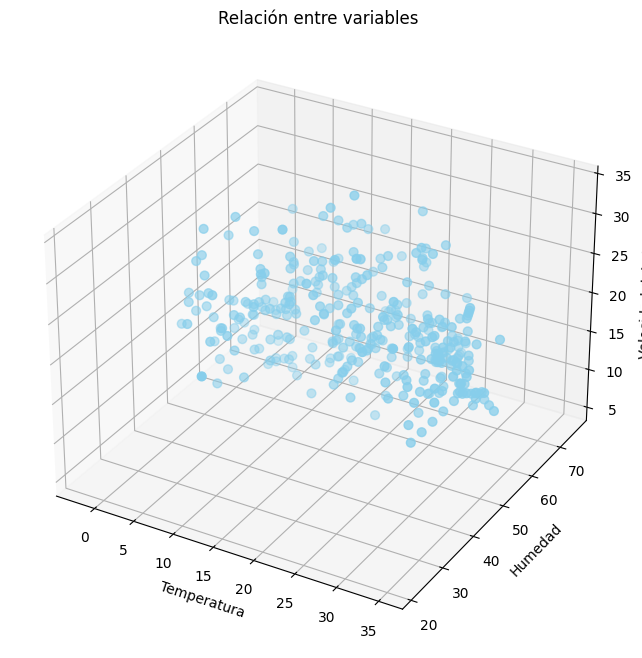

In [ ]:
# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
# La posición de los ejes es tal como se indica en el enlace superior.

# Título: Interpretar los resultados clave para Gráfica de dispersión 3D
# Url: https://support.minitab.com/es-mx/minitab/20/help-and-how-to/graphs/3d-scatterplot/interpret-the-results/key-results/

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[8,8])

ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['temperature'], train['humidity'], train['windspeed'], c='skyblue', s=40)
ax.set_xlabel('Temperatura')
ax.set_ylabel('Humedad')
ax.set_zlabel('Velocidad del viento')
ax.set_title('Relación entre variables')
plt.show()


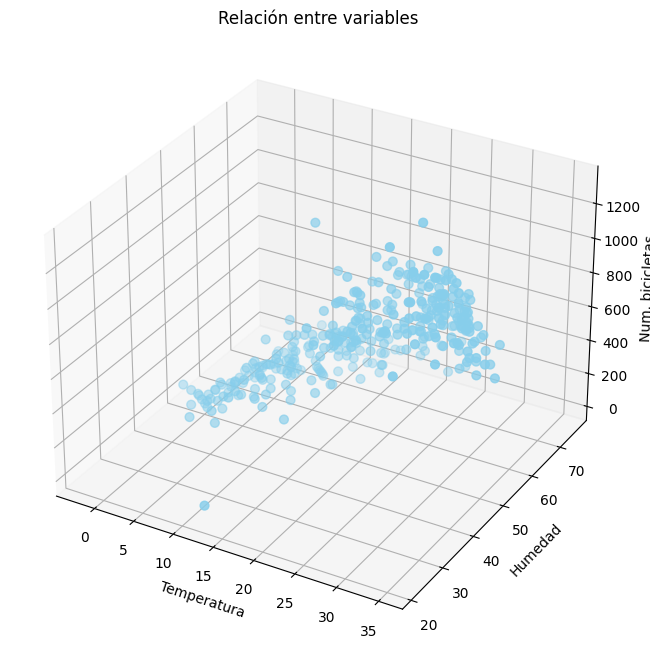

In [ ]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['temperature'], train['humidity'], train['count'], c='skyblue', s=40)
ax.set_xlabel('Temperatura')
ax.set_ylabel('Humedad')
ax.set_zlabel('Num. bicicletas')
ax.set_title('Relación entre variables')

plt.show()

In [ ]:
#Ejer 01: 1.	En lugar de utilizar un gráfico 3D para ver la correlación de la variables, montar el código para mostrarlo por medio de una matriz de correlación
#           , pero excluyendo la columna count. Y comparar/comentar el resultado con las features_importance (indicado más adelante) que ha deducido el modelo.


#1. Parametrización

Existen diferentes parámetros que se pueden optimizar para la utilización de RandomForests,  en este caso vamos a ceñirnos a a optimizar el número de estimadores (números de árboles en el bosque) que vamos a probar con distintas potencias de 2


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
cv = TimeSeriesSplit()

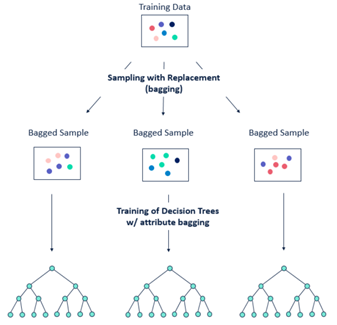

In [ ]:
from sklearn.ensemble import RandomForestRegressor # Utilizamos esta librería porque es un problema de regresión,
                                                   # corresponde al modelo comentado en la D25
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np


In [ ]:
# Vamos a representar en una gráfica el MAE en función del hiperparámetro n_estimator: número de árboles en el bosque
# consultar la ayuda conextual del modelo
#l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
l_estimators = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13,14,15,16,17,18,19,20]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   # Con el parámetro n_estimator se indica el número de árboles en el bosque
   # Recuerda que el parámetro criterioon es el criterio que se va a utilizar para medir la calidad de una división,
   #                                      es decir que las cosas que son similares deben estar juntas y las que son diferentes,
   #                                      deben separarse y distinguirse claramente unas de otras.
   #                                      Dependiendo del tipo de problema estos son los posibles valores:
   #                                             -> Clasificación: Gini, entropy
   #                                             -> Regresión: mse, mae, friedman, en la versión última (squared_error)
   # regressor =  RandomForestRegressor(n_estimators= estimators, criterion='mae', random_state=0)
   # En la nueva versión se sustituyó el error 'mae' por 'absolute_error', es equivalente
   regressor =  RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0)

   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = train.loc[train_fold]
      f_test = train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['count'], axis=1),
                           y = f_train['count'])
      y_pred = regressor.predict(X = f_test.drop(['count'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['count'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

print(total_scores)




[161.13111111111112, 157.21722222222223, 147.48148148148147, 150.84625, 149.79144444444447, 148.8449537037037, 147.64642857142854, 146.61013888888888, 148.1623765432099, 147.21733333333333, 148.55631313131312, 147.5895601851852, 146.37179487179486, 147.0224404761905, 145.9042962962963, 146.04362847222222, 146.9641176470588, 147.36368827160496, 148.63576023391812, 148.710375]


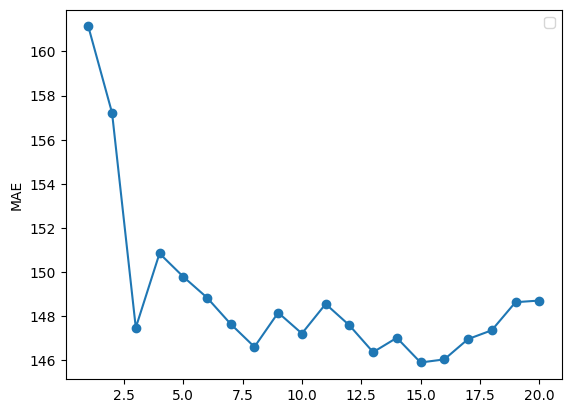

In [ ]:
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')


plt.legend()
plt.show()

In [ ]:
np.argmin(total_scores)

3

In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 16, MAE = 146.04)


# 2. Construcción y ejecución del modelo



Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error', random_state=0)
# fit and predict


for train_fold, test_fold in cv.split(train):
  # División train test aleatoria
  f_train = train.loc[train_fold]
  f_test = train.loc[test_fold]
  # entrenamiento y ejecución del modelo
  regressor.fit( X = f_train.drop(['count'], axis=1),
                        y = f_train['count'])

# MUY INTERESANTE: Entrenar sin CV y observar la diferencia del MAE, realizando el train SIN cv y CON cv
#regressor.fit( X = train.drop(['count'], axis=1), y = train['count'])
y_pred = regressor.predict(X = test.drop(['count'], axis = 1))

Calculamos el mae obtenido. Cuando se trata de una competición esta línea la ejecuta la propia competición

In [ ]:
mae = mean_absolute_error(test['count'], y_pred)
print ('MAE', mae)

MAE 247.18966302367943


Y guardamos el fichero de resultados en nuestro disco.

In [ ]:
# round the result and cast to int
import numpy as np
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
# generate output
# INTERESANTE: es una forma de comparar en una hoja de cálculo lo esperado (test) y lo predicho
output = pd.DataFrame({ 'date': test.index, 'result_predict': res, 'result_test': test['count']})


from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Por último, realizamos un gráfico para visualizar cómo ha quedado nuestra predicción con respecto a la realidad que se nos indica en el dataset.

In [ ]:
output

,date,result_predict,result_test
date,,,
2012-01-01,2012-01-01,96,290.000000
2012-01-02,2012-01-02,82,189.500000
2012-01-03,2012-01-03,73,89.000000
2012-01-04,2012-01-04,93,95.000000
2012-01-05,2012-01-05,184,140.000000
...,...,...,...
2012-12-27,2012-12-27,104,247.000000
2012-12-28,2012-12-28,118,644.000000
2012-12-29,2012-12-29,88,575.666667


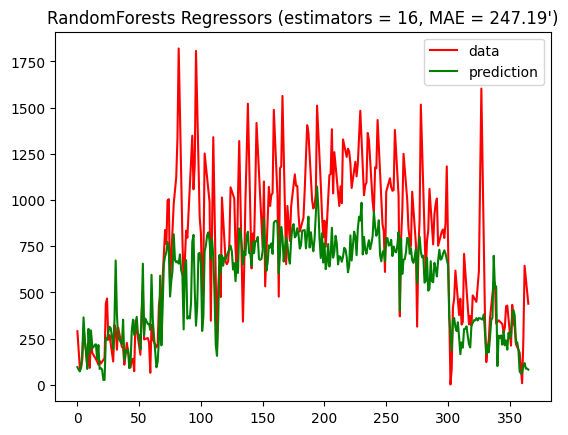

In [ ]:

from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.arange(test['count'].shape[0])
plt.plot(xx, test['count'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

plt.show()

In [ ]:
# FEATURE RELEVANCIES
# Muy interesante porque podemos observar la relavancia de las características a la hora de entrenar el modelo.
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('temperature', 'humidity', 'windspeed') ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,temperature,0.675692
1,humidity,0.192387
2,windspeed,0.131921


## 3. Comparativa entre diferentes modelos de árboles para el mismo problema

In [ ]:
# Duda: ¿A qué tipo/técnica de árbol de los indicados en las diapos corresponden estos modelos?
# En las diapos (D22..D25) se habla de :
#      ->  Bagging(Bootstrap aggregation)
#      ->  Random forest : Este es el ejemplo de las celdas anteriores (RandomForestRegressor)
#      ->  Boosted Trees

from sklearn.tree import DecisionTreeRegressor # Este es un modelo de un arbol individual, es decir no se utiliz la técnica de dividir el datset en subárboles
                                               # (D7) - Lo vimos en el ejemplo_3_7
from sklearn.ensemble import AdaBoostRegressor # Este pertenece a los modelos tipo Boosting (D25)
from sklearn.ensemble import GradientBoostingRegressor # Este pertenece a los modelos tipo Boosting (D25)
from sklearn.ensemble import BaggingClassifier # Este pertenece a los modelos tipo Bagging (D23)

# Fit regression model
regressors = []
regressors.append(DecisionTreeRegressor(max_depth=6, criterion='absolute_error'))

# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=6, criterion='absolute_error'), n_estimators=128, random_state=0))

# http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py
regressors.append(GradientBoostingRegressor(n_estimators=50, learning_rate=0.25, random_state=0, loss='squared_error'))

# No utilizamos el algoritmo para los árboles tipo Bagging porque el data set de ejemplo es un problema de tipo de regresión con valores continuos
# y da error al ejecutarse
#
# En este otro artículo se muestra un ejemplo con un problema de clasificación:
# https://vitalflux.com/bagging-classifier-python-code-example/
#
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
# regressors.append(BaggingClassifier(n_estimators=10, random_state=0))


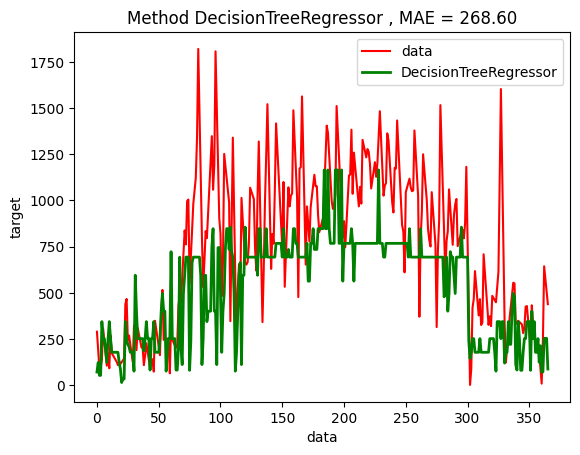

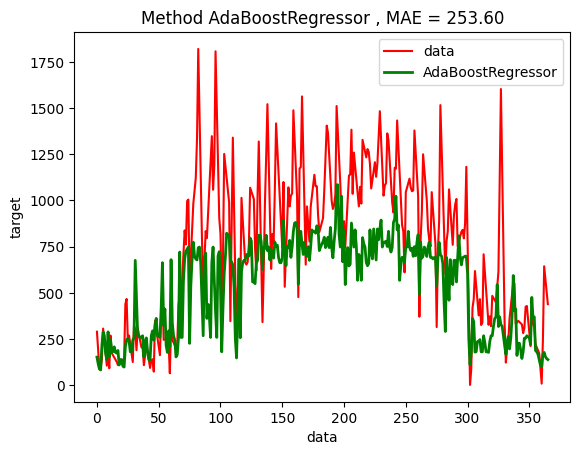

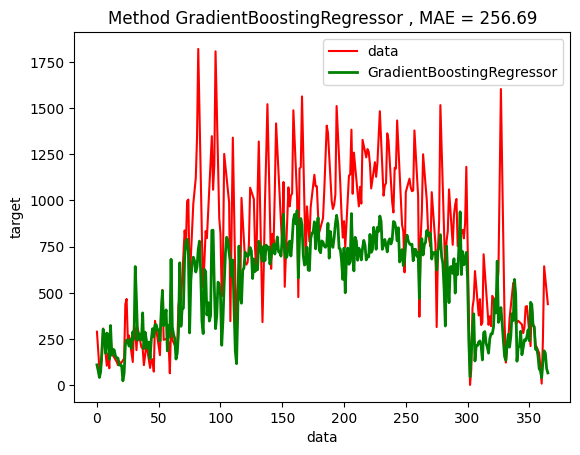

In [ ]:
# En la variable(array) xx guarda los valores del 0 al 365. Que corresponden con el número de muestras del conjunto de datos de test
xx = np.arange(test['count'].shape[0])
# DT -> DecisionTreeRegressor
# AB -> AdaBoostRegressor
# GB -> GradientBoostingRegressor

#regr_names = ["DT", "AB", "GB"]
regr_names = ["DecisionTreeRegressor", "AdaBoostRegressor", "GradientBoostingRegressor"]

results = pd.DataFrame()
results['real'] = test['count']

for i, r in enumerate(regressors):
    r.fit( X = train.drop(['count'], axis=1), y = train['count'])
    y = r.predict(X = test.drop(['count'], axis = 1))
    results[regr_names[i]] = y
    mae = mean_absolute_error(test['count'],y)
    # Plot the results
    plt.figure()
    plt.plot(xx, test['count'], c='r', label='data')
    plt.plot(xx, y, c="g", label=regr_names[i], linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Method %s , MAE = %6.2f" % (regr_names[i], mae ))
    plt.axis('tight')
    plt.legend()
    plt.show()

In [ ]:
results

,real,DecisionTreeRegressor,AdaBoostRegressor,GradientBoostingRegressor
date,,,,
2012-01-01,290.000000,72.0,152.500000,110.341046
2012-01-02,189.500000,123.0,116.166667,79.511332
2012-01-03,89.000000,53.5,88.000000,42.451846
2012-01-04,95.000000,53.5,83.000000,72.759281
2012-01-05,140.000000,344.5,216.000000,189.783759
...,...,...,...,...
2012-12-27,247.000000,72.0,167.000000,126.299627
2012-12-28,644.000000,254.0,178.000000,186.640716
2012-12-29,575.666667,254.0,155.000000,172.967514


In [ ]:
from google.colab import files


with open('results_comparativemodels.xlsx', 'wb') as f:
  results.to_excel(f,  index = True)


files.download('results_comparativemodels.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Ejer 02: Aplicando la técnica de Cross Validation, realizar la comparativa entre los diferentes modelos.
# Para ello utilizaremos como métrica de calidad el MAE, Ya que es el que utilizamos en el código de ejemplo. No utilizar la clase cross_val_score


In [ ]:
# Ejer 03: Obtener en un único fichero Excel los resultados obtenidos en todos los modelos utilizados.

In [ ]:
# Ejer 04: Para analizar los resultados obtenidos en este problema, ¿tendría sentido utilizar la matriz de confusión?. Explicarlo